## 1. Region Proposals
Region Proposal 은 유사한 픽셀들과의 지역에 대한 강조를 돕기 위한 기술이다.

### (1) Selective Search to generate region proposals
- 아래 scale 값은 유사한 픽셀들간의 지역을 200개의 값으로 하여 구분해주는 이미지의 색상 값으로 분류된 모습이다.

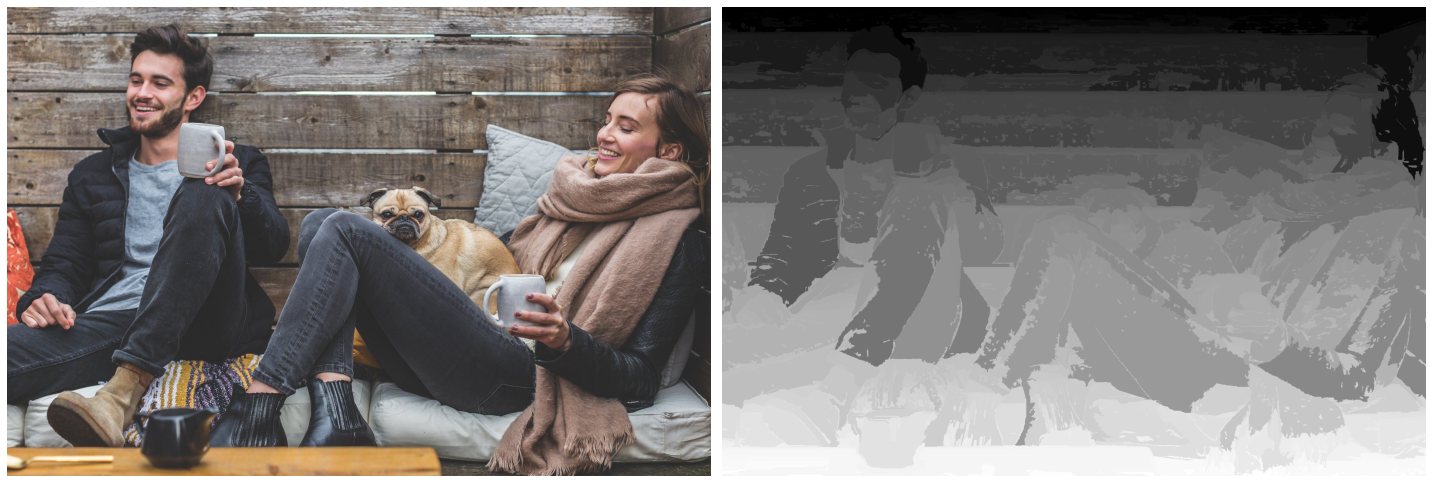

In [23]:
import torch
from torch_snippets import *
import selectivesearch
from skimage.segmentation import felzenszwalb

img = read('./images/man.jpg',1)
segments_fz = felzenszwalb(img, scale=200)
subplots([img,segments_fz],figsize=(20,20))

### (2) 박스 그려보기
- 박스는 selective search 에 의해 도출된 region proposals 을 그린 것이다.

In [24]:
def extract_candidates(img):
    _, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []

    for r in regions:
        if r['rect'] in candidates:continue
        if r['size'] < (0.05 * img_area) : continue
        if r['size'] > (1 * img_area): continue

        x,y,w,h = r['rect']
        candidates.append(list(r['rect']))
        
    return candidates

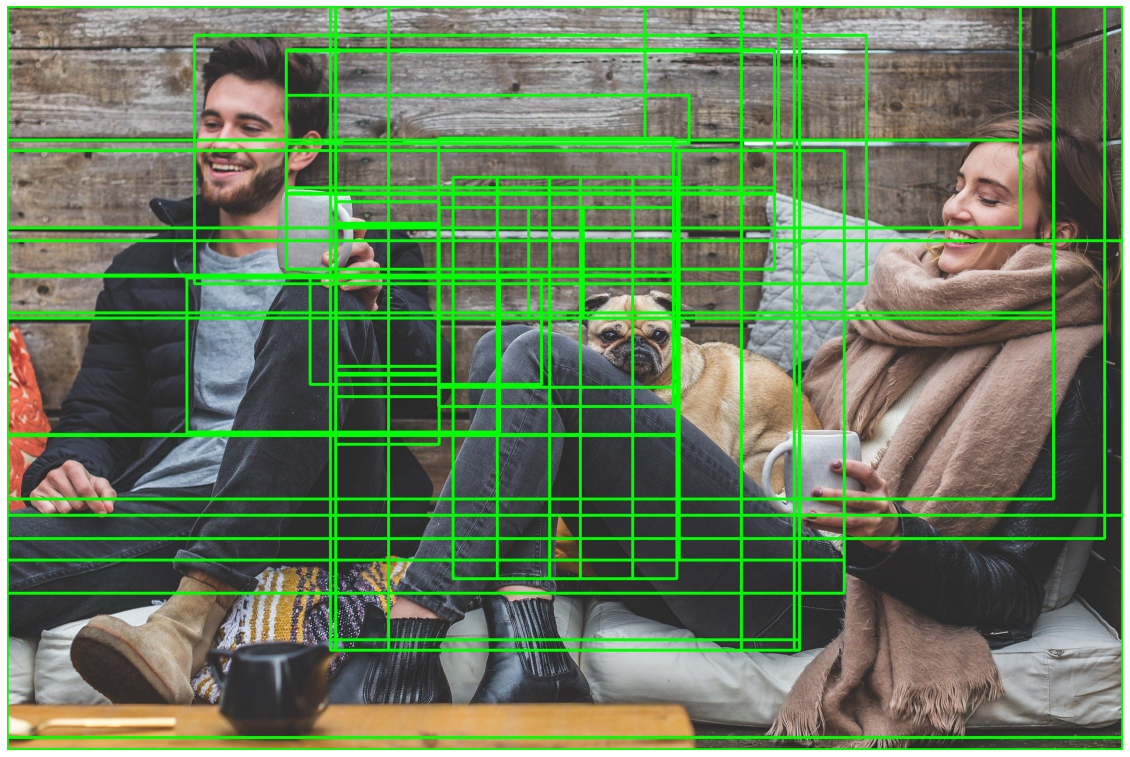

In [25]:
candidates = extract_candidates(img)
show(img, bbs = candidates)

## 2. IOU
객체 탐지 영역에서의 정확도를 측정하기 위한 방법
- 예측된 영역과 실제 영역의 교집합 / 예측된 영역과 실제 영역의 전체 넓이의 합집합

<img src = './images/IOU.JPG' height = 400px>

<img src = './images/IOU_2.JPG' height = 400px>

## 3. NMS(Non-max suppression)
- 현재 픽셀을 기준으로 주변의 픽셀과 비교했을 때 최대값인 경우 그대로 놔두고, 아닐 경우(비 최대) 억제(제거)하는 것이다. 
- 딥러닝을 이용한 Object Detection에서는 대부분 각종 boundingbox + 각 box에 object가 있을 확률 (class별 확률)들이 나오게 되는데, 이중 겹치는 부분(차 한대에 여러가지 boundingbox가 그려지는 경우와 같은)을 제거하기 위한 방법으로 사용된다.

## 4. Map(Mean average precision)
mAP는 모든 점 보간법을 이용해서 AP를 구한 값의 평균
즉, 여러 Class에 대한 AP를 구해야 하므로, 각각의 Class에 대해 AP를 구하고 평균을 산출

- AP 곡선(Average Precision curve)은 Precision과 Recall을 고려한 종합적 평가 지표이며, 실제로 AP는 0~1 사이의 모든 Recall에 대응하는 평균 Precision

In [1]:
from torch_snippets import *
import selectivesearch
from torchvision import transforms, models, datasets
from torch_snippets import Report
from torchvision.ops import nms
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import pandas as pd
import numpy as np

In [2]:
IMAGE_ROOT = './dataset/images/images'
df_raw = pd.read_csv('./dataset/df.csv')
print(df_raw.head())

            ImageID  Source LabelName  Confidence      XMin      XMax  \
0  0000599864fd15b3  xclick       Bus           1  0.343750  0.908750   
1  00006bdb1eb5cd74  xclick     Truck           1  0.276667  0.697500   
2  00006bdb1eb5cd74  xclick     Truck           1  0.702500  0.999167   
3  00010bf498b64bab  xclick       Bus           1  0.156250  0.371250   
4  00013f14dd4e168f  xclick       Bus           1  0.287500  0.999375   

       YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  IsInside  \
0  0.156162  0.650047           1            0  ...            0         0   
1  0.141604  0.437343           1            0  ...            0         0   
2  0.204261  0.409774           1            1  ...            0         0   
3  0.269188  0.705228           0            0  ...            0         0   
4  0.194184  0.999062           0            1  ...            0         0   

   XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
0  0.421875  0.34

In [3]:
class OpenImages(Dataset):
    def __init__(self, df, image_folder=IMAGE_ROOT):
        self.root = image_folder
        self.df = df
        self.unique_images = df['ImageID'].unique()
        
    def __len__(self): 
        return len(self.unique_images)

    def __getitem__(self, ix):
        image_id = self.unique_images[ix]
        image_path = f'{self.root}/{image_id}.jpg'
        # BGR을 RGB로 바꿔주기
        image = cv2.imread(image_path, 1)[...,::-1] 
        h, w, _ = image.shape
        df = self.df.copy()
        df = df[df['ImageID'] == image_id]
        boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
        boxes = (boxes * np.array([w,h,w,h])).astype(np.uint16).tolist()
        classes = df['LabelName'].values.tolist()
        return image, boxes, classes, image_path

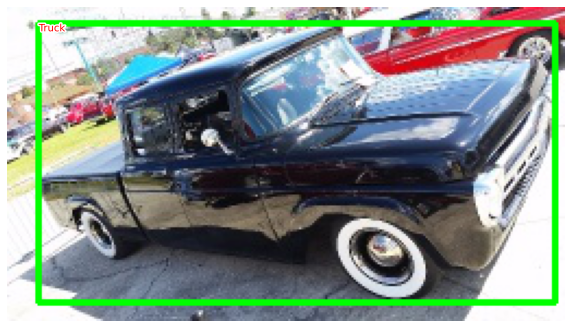

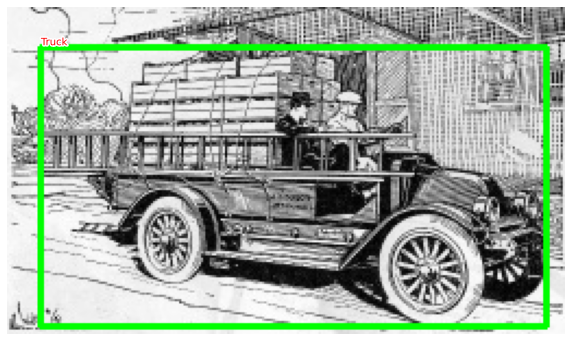

In [4]:
ds = OpenImages(df = df_raw)
im, bbs, clss , _ = ds[5]
show(im, bbs = bbs, texts = clss, sz = 10)
im, bbs, clss , _ = ds[4]
show(im, bbs = bbs, texts = clss, sz = 10)

In [5]:
# IOU 계산해보기
def extract_candidates(img):
    img_lbl, regions = selectivesearch.selective_search(img,scale = 200, min_size = 100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] in (0.05 * img_area) : continue
        if r['size'] in (1 * img_area) : continue
        x,y,w,h = r['rect']
        candidates.append(list(r['rect']))

def extract_iou(boxA, boxB, epsilon = 1e-5):
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = max(boxA[2], boxB[2])
    y2 = max(boxA[3], boxB[3])
    width = (x2 - x1)
    height = (y2 - y1)

    if width <0 or height <0:
        return 0.0
    
    area_overlap = width * height
    area_a = (boxA[2] - boxA[0]) * (boxB[3] - boxB[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined + epsilon)
    return iou